In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

In [2]:
case = pd.read_csv("data/data/covid_19.csv")

In [3]:
case["submission_date"] = case["submission_date"].astype("datetime64")
case = case.loc[:, ["submission_date", "state", "tot_cases", "new_case"]]
case["lag_date"] = case["submission_date"].shift(1)

In [4]:
join = pd.merge(case, case, how="left", left_on = ["submission_date", "state"], right_on = ["lag_date", "state"])
join["inc_rate"] = join["new_case_y"] / join["tot_cases_x"] 
join = join.fillna(0)

In [5]:
def helper1(state):
    tmp = join[join["state"] == state].reset_index(drop=True)
    inf_ind = np.where(tmp.inc_rate==math.inf)[0]
    return tmp.loc[inf_ind[0]+1:, ["submission_date_x", "state", "inc_rate"]] if inf_ind else tmp.loc[:, ["submission_date_x", "state", "inc_rate"]]
    
case_ = pd.concat([helper1(x) for x in np.unique(join["state"])],axis=0).reset_index(drop=True)
case_.columns = ["date", "state", "inc_rate"]

In [6]:
def helper2(state, shift=1):
    tmp = case_[case_["state"] == state]
    for i in range(1, shift+1):
        varname = "lag_" + str(i)
        tmp[varname] = tmp["inc_rate"].shift(i)
    return tmp

data = pd.concat([helper2(x, shift=7) for x in np.unique(join["state"])],axis=0).dropna().reset_index(drop=True)

### hospital

In [7]:
hos2 = pd.read_csv("data/data/hospital2.csv")
d = {"APR": 4, "MAY": 5, "JUN": 6, "JUL": 7}
hos2["month"] = hos2[["month"]].applymap(lambda x: d[x])
hos2["date"] = pd.to_datetime(hos2[['year', 'day', 'month']]) # concat date
hos2 = hos2.filter(["date", "state"] + hos2.columns[hos2.columns.str.contains("Est")].to_list(), axis=1)

var_list = ["InpatBeds_Occ_AnyPat_Est", "InpatBeds_Occ_AnyPat_Est_Avail", "InpatBeds_Occ_COVID_Est", "ICUBeds_Occ_AnyPat_Est", "ICUBeds_Occ_AnyPat_Est_Avail"]

for var in var_list: ## log-scale the discrete variables 
    hos2["Log_"+var] = np.log(hos2[var]+1)
    hos2 = hos2.drop(var, axis=1)

In [14]:
case_hos = pd.merge(data, hos2, how='inner', on=['state', 'date'])
case_hos.head()

,date,state,inc_rate,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,InBedsOccAnyPat__Numbeds_Est,InBedsOccCOVID__Numbeds_Est,ICUBedsOccAnyPat__N_ICUBeds_Est,Log_InpatBeds_Occ_AnyPat_Est,Log_InpatBeds_Occ_AnyPat_Est_Avail,Log_InpatBeds_Occ_COVID_Est,Log_ICUBeds_Occ_AnyPat_Est,Log_ICUBeds_Occ_AnyPat_Est_Avail
0,2020-04-01,AK,0.027972,0.075188,0.117647,0.043860,0.117647,0.200000,0.231884,0.169492,57.6,4.3,54.7,6.278521,5.973810,3.713572,4.418841,4.234107
1,2020-04-02,AK,0.068027,0.027972,0.075188,0.117647,0.043860,0.117647,0.200000,0.231884,56.7,5.6,48.0,6.263398,5.993961,3.970292,4.290459,4.369448
2,2020-04-03,AK,0.089172,0.068027,0.027972,0.075188,0.117647,0.043860,0.117647,0.200000,55.2,5.2,42.7,6.236370,6.028279,3.891820,4.174387,4.465908
3,2020-04-04,AK,0.081871,0.089172,0.068027,0.027972,0.075188,0.117647,0.043860,0.117647,49.0,2.6,44.7,6.398595,6.439350,3.496508,4.304065,4.521789
4,2020-04-05,AK,0.032432,0.081871,0.089172,0.068027,0.027972,0.075188,0.117647,0.043860,48.5,3.9,51.8,6.388561,6.448889,3.912023,4.454347,4.382027


In [19]:
case_hos.shape

(4934, 18)

### policy

In [11]:
policy = pd.read_csv("data/data/policy.csv")

In [12]:
def generate_policy(var_name, data, start, end = None):
    policy[start] = pd.to_datetime(policy[start],errors = "coerce")
    if end == None:
        temp = pd.merge(data, policy[["POSTCODE",start]], how = "inner", 
                        left_on = "state", right_on = "POSTCODE")
        output = []
        for i in range(temp.shape[0]):
            if pd.isnull(temp[start][i]) or temp["date"][i] < temp[start][i]:
                output.append(0)
            else:
                output.append(1)
        temp = temp.drop(["POSTCODE",start],axis = 1)
    else:
        policy[end] = pd.to_datetime(policy[end],errors = "coerce")
        temp = pd.merge(data, policy[["POSTCODE", start, end]], how = "inner", 
                        left_on = "state", right_on = "POSTCODE")
        output = []
        for i in range(temp.shape[0]):
            if pd.isnull(temp[start][i]):
                output.append(0)
            elif temp["date"][i] < temp[start][i] or temp["date"][i] >= temp[end][i]:
                output.append(0)
            else:
                output.append(1)
        temp = temp.drop(["POSTCODE",start,end], axis = 1)
    temp[var_name] = output
    return temp

In [40]:
case_hos_plc = case_hos.copy()

for var_name, start, end in [('stay at home order', 'STAYHOME(start)', 'END_STHM(end)'),
                             ('face mask mandatory', 'FM_ALL(start)', None),
                             ('restaurant closed', 'CLREST(start)', 'ENDREST(end)'),
                             ('business closed', 'CLBSNS(start)', 'END_BSNS(end)')]:
    case_hos_plc = generate_policy(var_name, case_hos_plc, start, end)

tmp = policy.loc[:,['POSTCODE','RELIGEX(attribute)','FMFINE(attribute)']].rename({'POSTCODE':'state',
             'RELIGEX(attribute)':'religious gathering forbidden',
             'FMFINE(attribute)':'face mask fine'}, axis=1)
case_hos_plc = pd.merge(case_hos_plc, tmp, how='inner', on='state')

### Population

### Random Forest Model

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = case_hos_plc.iloc[:, 3:]
y = case_hos_plc.iloc[:, 2]

idx_train = case_hos_plc["date"] <= "2020-06-01"
idx_test = case_hos_plc["date"] > "2020-06-01"

columns = X.columns

X_train = X.loc[idx_train, :]
X_test = X.loc[idx_test, :]
y_train = y[idx_train]
y_test = y[idx_test]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000, 21) (1836, 21) (3000,) (1836,)


In [47]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [48]:
def rmse(y, y_pred):
    return np.sqrt(((y-y_pred)**2).mean())

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rmse(rf.predict(X_train), y_train))
print(rmse(rf.predict(X_test), y_test))

0.010757863993054156
0.010607404793081325


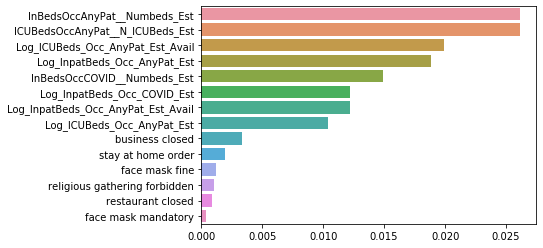

In [49]:
from sklearn.inspection import permutation_importance
importances = permutation_importance(rf, X_train, y_train)

idx = np.argsort(-importances['importances_mean'])[7:]
sns.barplot(importances['importances_mean'][idx], columns[idx]);

In [82]:
def rf_by_state(state='NC'):
    tmp = case_hos_plc.loc[case_hos_plc['state']==state, ].copy()

    X_s = tmp.iloc[:, 3:]
    y_s = tmp.iloc[:, 2]

    for column in X_s.columns:
        if len(X_s[column].unique()) == 1:
            X_s = X_s.drop(column, axis=1)

    idx_train_s = tmp["date"] <= "2020-06-01"
    idx_test_s = tmp["date"] > "2020-06-01"

    columns = X_s.columns

    X_train_s = X_s.loc[idx_train, :]
    X_test_s = X_s.loc[idx_test, :]
    y_train_s = y_s[idx_train]
    y_test_s = y_s[idx_test]

    ss = StandardScaler()

    ss.fit(X_train_s)
    X_train_s = ss.transform(X_train_s)
    X_test_s = ss.transform(X_test_s)
    rf = RandomForestRegressor()
    rf.fit(X_train_s, y_train_s)
    train = rmse(rf.predict(X_train_s), y_train_s)
    test = rmse(rf.predict(X_test_s), y_test_s)
    
    importances = permutation_importance(rf, X_train_s, y_train_s)

    idx = np.setdiff1d(np.argsort(-importances['importances_mean']),
                       [0,1,2,3,4,5,6], assume_unique=True)
    sns.barplot(importances['importances_mean'][idx], columns[idx])
    
    return train, test

(0.016430309594132633, 0.01404962191560224)

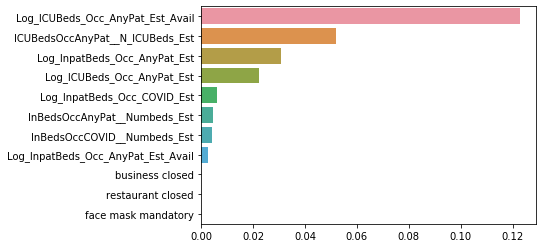

In [83]:
rf_by_state('CA')